Data gotten from [GeeksforGeeks](https://www.geeksforgeeks.org/dataset-for-linear-regression/?utm_source=chatgpt.com#student-performance-dataset) 

This dataset contains information about students' academic performance, including attributes such as parents' education level, test preparation score and others.

In [99]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score 
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


In [67]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # Change column name for easier access 
    df['race'] = df['race/ethnicity']
    df.drop(columns='race/ethnicity', inplace=True)

    # Create average_score column
    df["average_score"] = df[["math score", "reading score", "writing score"]].mean(axis=1)

    # Drop individual scores to avoid leakage
    df.drop(columns=["math score", "reading score", "writing score"], inplace=True)
    
    return df

In [68]:
df = wrangle('StudentsPerformance[1].csv')
df.head()

,gender,parental level of education,lunch,test preparation course,race,average_score
0,female,bachelor's degree,standard,none,group B,72.666667
1,female,some college,standard,completed,group C,82.333333
2,female,master's degree,standard,none,group B,92.666667
3,male,associate's degree,free/reduced,none,group A,49.333333
4,male,some college,standard,none,group C,76.333333


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   parental level of education  1000 non-null   object 
 2   lunch                        1000 non-null   object 
 3   test preparation course      1000 non-null   object 
 4   race                         1000 non-null   object 
 5   average_score                1000 non-null   float64
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [70]:
df.describe()

,average_score
count,1000.000000
mean,67.770667
std,14.257326
min,9.000000
25%,58.333333
50%,68.333333
75%,77.666667
max,100.000000


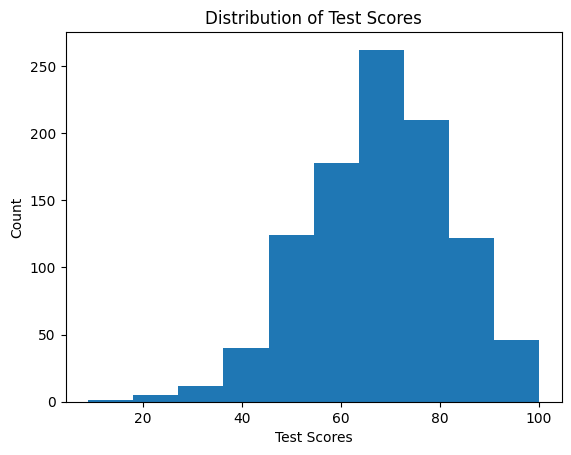

In [71]:
plt.hist(x=df['average_score'])
plt.xlabel('Test Scores')
plt.ylabel('Count')
plt.title('Distribution of Test Scores');

**Exploratory Data Analysis (EDA)**

Visualize the top 10 scorers

In [72]:
df_sorted = df.sort_values('average_score', ascending=False)
top_10 = df_sorted.head(10)
top_10

,gender,parental level of education,lunch,test preparation course,race,average_score
916,male,bachelor's degree,standard,completed,group E,100.000000
962,female,associate's degree,standard,none,group E,100.000000
458,female,bachelor's degree,standard,none,group E,100.000000
114,female,bachelor's degree,standard,completed,group E,99.666667
712,female,some college,standard,none,group D,99.000000
179,female,some high school,standard,completed,group D,99.000000
165,female,bachelor's degree,standard,completed,group C,98.666667
625,male,some college,standard,completed,group D,98.666667
685,female,master's degree,standard,completed,group E,97.666667
903,female,bachelor's degree,free/reduced,completed,group D,97.666667


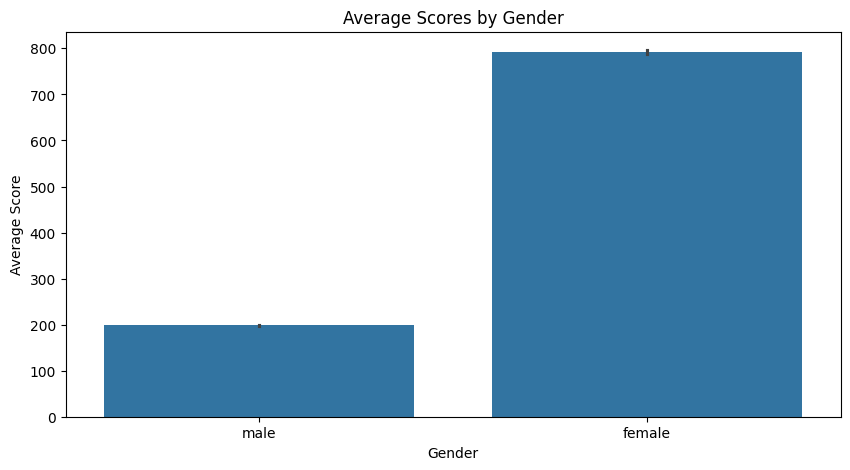

In [73]:
plt.figure(figsize=(10, 5))
sns.barplot(x="gender", y="average_score", data=top_10, estimator=sum)
plt.xlabel("Gender")
plt.ylabel("Average Score")
plt.title("Average Scores by Gender")

plt.show()

Females constitute 80% of the top scorers🤩


The top scorers are in group E race (Mixed- White and Black African)    


(*I'm not shocked😌*)

*Relationship between columns*

Parent Level of Education and Average Score

In [74]:
print('The levels are:')
for level in df['parental level of education'].unique():
    print(f'- {level}')

The levels are:
- bachelor's degree
- some college
- master's degree
- associate's degree
- high school
- some high school


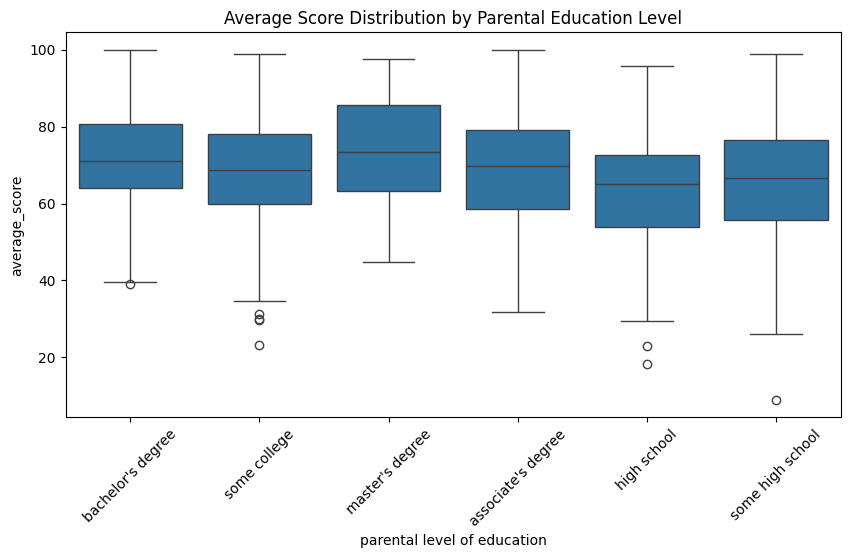

In [75]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='parental level of education', y='average_score', data=df)
plt.xticks(rotation=45) 
plt.title('Average Score Distribution by Parental Education Level')
plt.show()

Parents who have master's degree, bachelor's degree and associate's degree tend to have students who score higher

Gender and Average Score

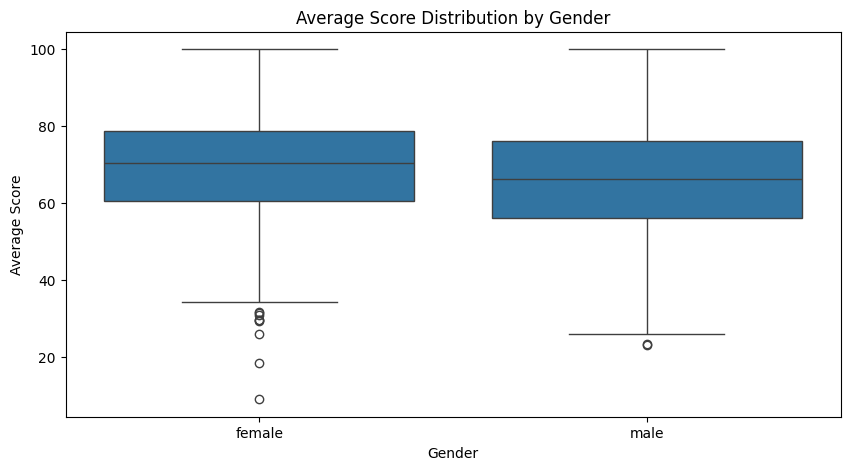

In [76]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='gender', y='average_score', data=df)
plt.xlabel('Gender')
plt.ylabel('Average Score')
plt.title('Average Score Distribution by Gender')
plt.show()

As observed earlier, there are more females who score higher than males 

*(Honestly, I'm not suprised)*

Race and Average Score

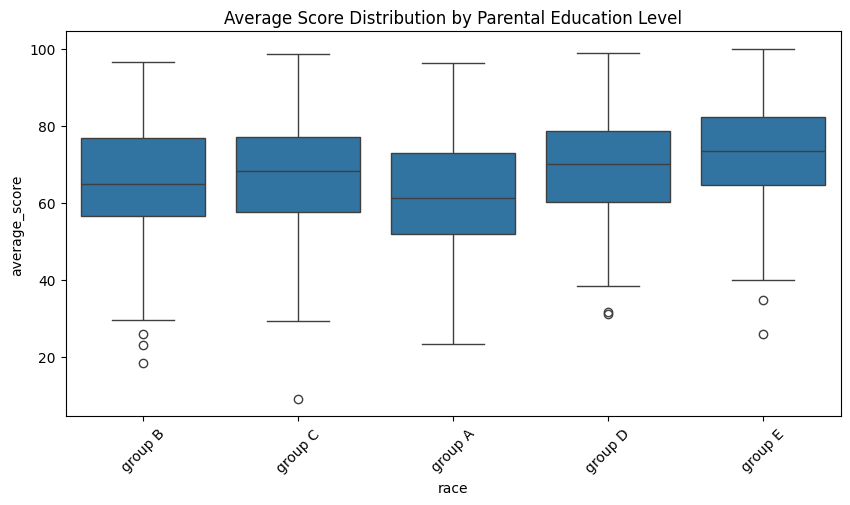

In [77]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='race', y='average_score', data=df)
plt.xticks(rotation=45)
plt.title('Average Score Distribution by Parental Education Level')
plt.show()

As observed, mixed students (Group D & E) perform better and white students (Group A) perform worse

Test Preparation and Average Score

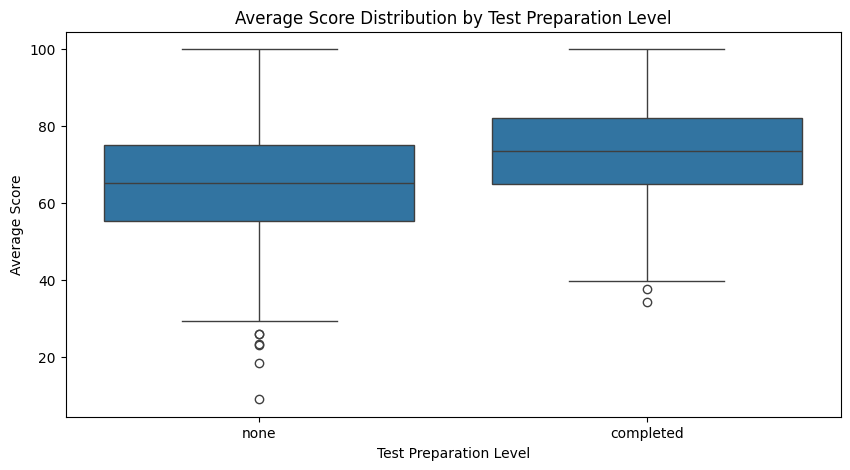

In [78]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='test preparation course', y='average_score', data=df)
plt.xlabel('Test Preparation Level')
plt.ylabel('Average Score')
plt.title('Average Score Distribution by Test Preparation Level')
plt.show()

In [79]:
df['test preparation course'].value_counts()

test preparation course
none         642
completed    358
Name: count, dtype: int64

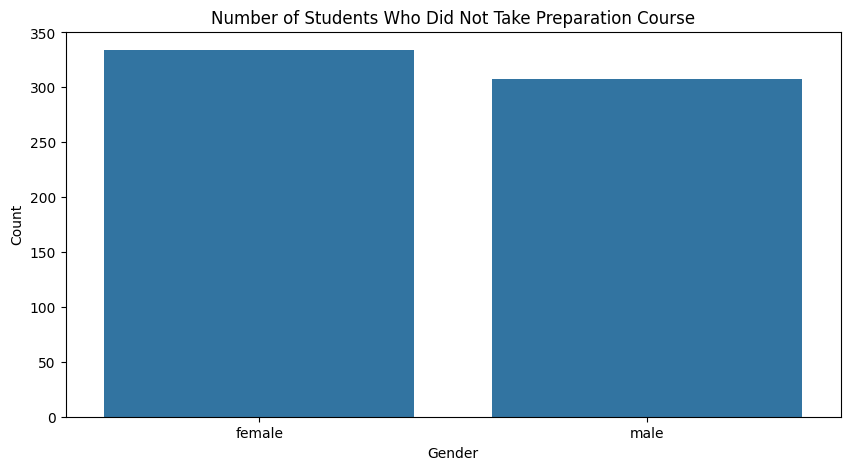

In [80]:
not_test = df[df['test preparation course'] == 'none']
gender_counts = not_test["gender"].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Number of Students Who Did Not Take Preparation Course')
plt.show()

Through normal logic, students who take the preparation course perform better than those who don't

64% of students did not take the preparation course and females were the larger population

Lunch and Average Score

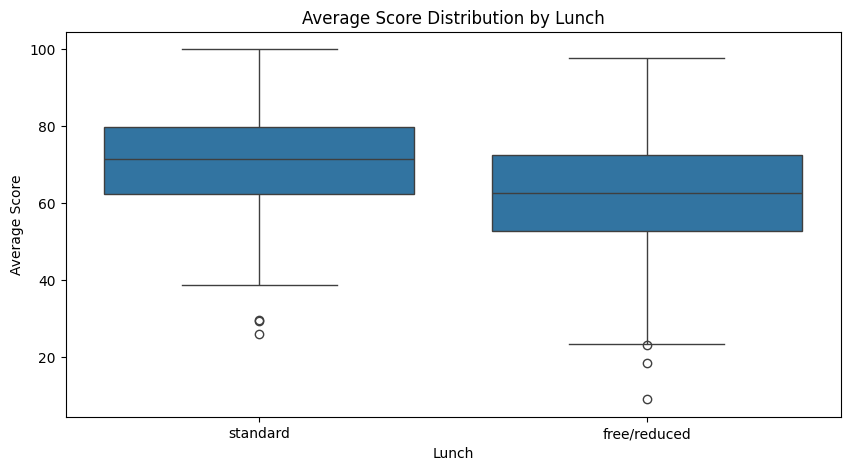

In [81]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='lunch', y='average_score')
plt.xlabel('Lunch')
plt.ylabel('Average Score')
plt.title('Average Score Distribution by Lunch')
plt.show()

Students who can afford standard meal perform better than those who can't

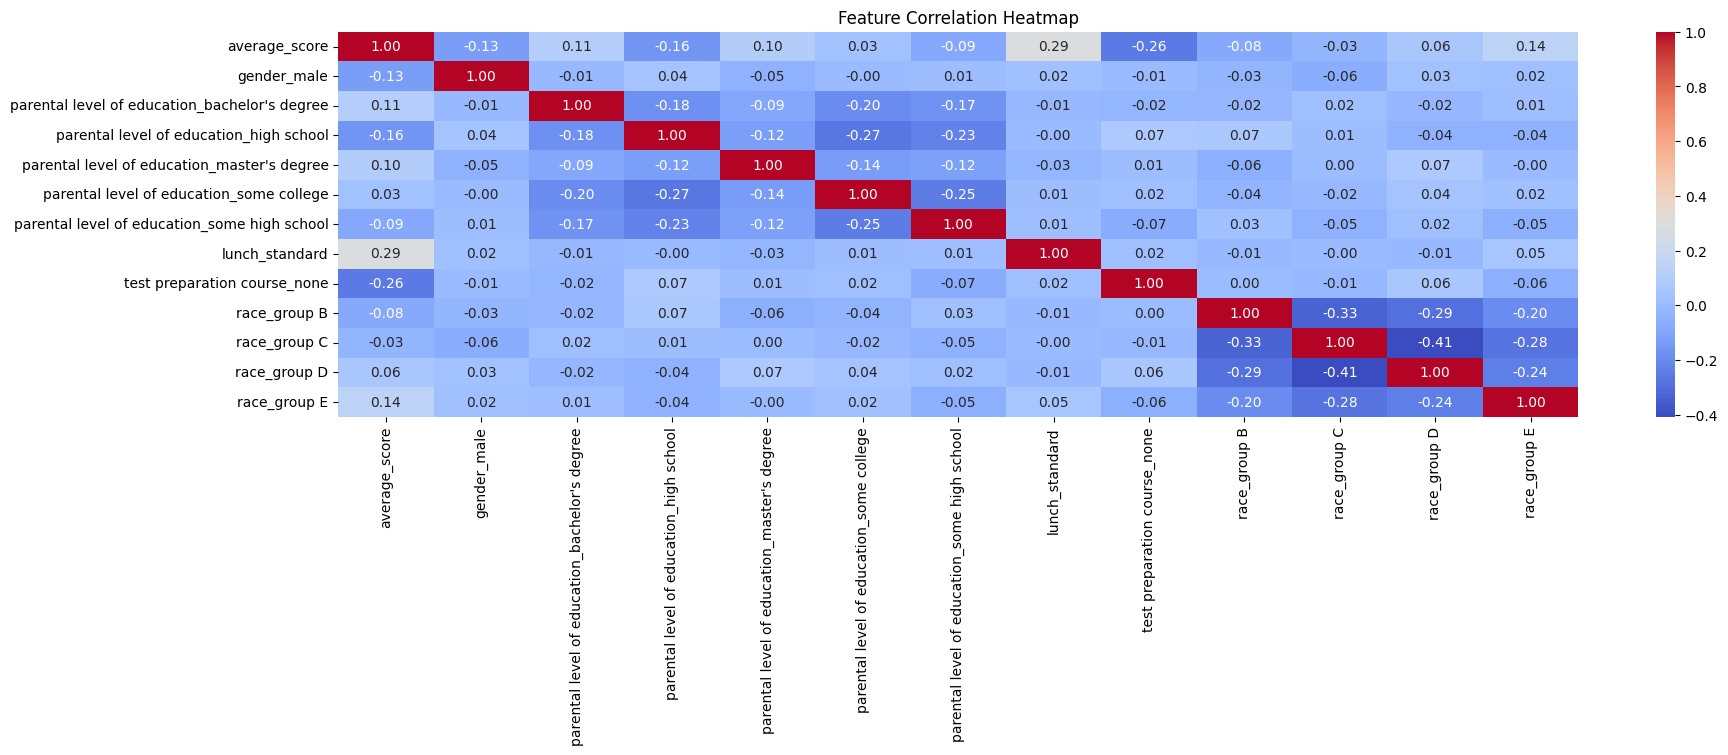

In [107]:
df_encoded = pd.get_dummies(df, columns=['gender', 'parental level of education', 'lunch', 'test preparation course', 'race'], drop_first=True)

corr_matrix = df_encoded.corr()

plt.figure(figsize=(20,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

**Build Model**

Split data

In [83]:
features = ['parental level of education', 'lunch', 'test preparation course', 'race']
target = 'average_score'

X_train, X_test, y_train, y_test = train_test_split(
  df[features], df[target] , random_state=42, test_size=0.25)

Baseline Model

In [84]:
y_mean = round(y_train.mean(), 2)
y_pred_baseline = [y_mean] * len(y_train)
base_mae = round(mean_absolute_error(y_train, y_pred_baseline), 2)
print(f'The mean score is {y_mean}')
print(f'The mean absolute error is {base_mae}')

The mean score is 68.34
The mean absolute error is 11.21


Iterate

In [85]:
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['parental level of education', 'lunch',
                                     'test preparation course', 'race'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

Evaluate

In [86]:
y_pred_train = model.predict(X_train)
train_mae = round(mean_absolute_error(y_train, y_pred_train), 2)
print(f'The training MAE is: {train_mae}')

The training MAE is: 9.94


In [87]:
y_pred_test = model.predict(X_test)
test_mae = round(mean_absolute_error(y_test, y_pred_test), 2)
print(f'The test MAE is: {test_mae}')

The test MAE is: 10.55


In [100]:
r2 = r2_score(y_test, y_pred_test)
print("R² Score:", r2)

R² Score: 0.1772145165595278


This low R² score may be due to the fact that there isn't enough information provided

Communicate

In [91]:
def get_grade(score):
    if score >= 90:
        return f'The predicted score is {score} with the grade A'
    elif score >= 80:
        return f'The predicted score is {score} with the grade B'
    elif score >= 70:
        return f'The predicted score is {score} with the grade C'
    elif score >= 60:
        return f'The predicted score is {score} with the grade D'
    else:
        return f'The predicted score is {score} with the grade E'

In [92]:
def make_prediction(parent_education, lunch, prep_score, race):
    data = [[parent_education, lunch, prep_score, race]]
    df = pd.DataFrame(data, columns=features)
    prediction = model.predict(df)

    return get_grade(round(prediction[0]))
    

In [96]:
make_prediction("master's degree", 'standard', 'none', 'group E')

'The predicted score is 75 with the grade C'